In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.utils.data import random_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

In [2]:
def fn(x):

    noise = 2 * torch.rand(x.shape[0], 1) - 1
    return (torch.sin(x[:, 0].unsqueeze(1)) + torch.cos(x[:, 1].unsqueeze(1)) + torch.tan(x[:, 1].unsqueeze(1))) + noise # x[:, 0] are xs; x[:, 0] are the ys

class x_y_ds(Dataset):
    def __init__(self, fn, N):

        self.xs = torch.rand(N, 2)
        self.ys = fn(self.xs)

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]
    
data = x_y_ds(fn, N = 100)
training_dataset, test_dataset = random_split(
    data, [80, 20]
)
    
train_dataloader = DataLoader(dataset = training_dataset, batch_size=15, shuffle=True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=15, shuffle=False)

In [3]:
def loss_fn(y_hat, y, ws, lambda_reg = 0.01):
    reg = lambda_reg * torch.sum(ws**2)
    return ((y_hat - y)**2) + reg

def loss_grad(y_hat, y):
    return 2 * (y_hat - y)

In [4]:
lr = 0.01
lambda_regs = [0, 0.001, 0.005, 0.01, 0.1, 0.5]
epochs = 100

# ws_history = []
# loss_history = []

epoch_loss_train_histories = {}
epoch_loss_test_histories = {}

for lambda_reg in lambda_regs:
    ws = torch.tensor([0.5, 0.6])
    b = torch.tensor([0.5])

    old_train_loss = None
    old_test_loss = None
    is_training_converged = False
    is_testing_converged = False

    epoch_loss_train_histories[lambda_reg] = {"ws_history": [], "loss_history": [], "epoch_loss_train_history": [], "training_convergence_epoch": None}
    epoch_loss_test_histories[lambda_reg] = {"epoch_loss_test_history": [], "testing_convergence_epoch": None}

    
    for epoch in range(epochs):
        epoch_loss_train = 0
        num_batches = 0
        # ws_epoch = torch.zeros((2))
        for x_batch, y_batch in train_dataloader:

            bs = y_batch.shape[0]
            y_hat = (x_batch @ ws).unsqueeze(1) + b # prediction
            losses_train = loss_fn(y_hat, y_batch, ws, lambda_reg).mean() # loss
            epoch_loss_train += losses_train
            # updation
            delta = loss_grad(y_hat, y_batch)
            ws -= lr * (((x_batch.T @ delta).squeeze() / bs) + (2 * lambda_reg * ws))
            b -= lr * (delta.mean())

            epoch_loss_train_histories[lambda_reg]["ws_history"].append(ws.detach().clone())
            epoch_loss_train_histories[lambda_reg]["loss_history"].append(losses_train.item())

            num_batches += 1

        epoch_loss_train /= num_batches
        epoch_loss_train_histories[lambda_reg]["epoch_loss_train_history"].append(epoch_loss_train.item())

        # checking convergence
        if old_train_loss is None:
            old_train_loss = epoch_loss_train
        else:
            if (abs(epoch_loss_train - old_train_loss) < 0.1) and epoch_loss_train < 0.4 and (is_training_converged == False):
                 is_training_converged = True 
                 epoch_loss_train_histories[lambda_reg]["training_convergence_epoch"] = epoch
            old_train_loss = epoch_loss_train
        ### testing
        epoch_loss_test = 0
        num_batches = 0
        for x_batch, y_batch in test_dataloader:
            bs = y_batch.shape[0]
            y_hat = (x_batch @ ws).unsqueeze(1) + b # prediction
            losses_test = loss_fn(y_hat, y_batch, ws, lambda_reg).mean() # loss
            epoch_loss_test += losses_test
            num_batches += 1
        epoch_loss_test /= num_batches
        epoch_loss_test_histories[lambda_reg]["epoch_loss_test_history"].append(epoch_loss_test.item())

        # checking convergence
        if old_test_loss is None:
             old_test_loss = epoch_loss_test
        else:
            if ((epoch_loss_test - old_test_loss) < 0.1) and (epoch_loss_test < 0.4) and (is_testing_converged == False):
                is_testing_converged = True 
                epoch_loss_test_histories[lambda_reg]["testing_convergence_epoch"] = epoch

        if epoch % 5 == 0:
                print(f"Epoch {epoch} | train loss = {epoch_loss_train:.4f} | test loss = {epoch_loss_test:.4f}")
            

Epoch 0 | train loss = 0.9439 | test loss = 1.0990
Epoch 5 | train loss = 0.4087 | test loss = 0.5423
Epoch 10 | train loss = 0.3328 | test loss = 0.4040
Epoch 15 | train loss = 0.3194 | test loss = 0.3720
Epoch 20 | train loss = 0.3332 | test loss = 0.3617
Epoch 25 | train loss = 0.3086 | test loss = 0.3612
Epoch 30 | train loss = 0.3174 | test loss = 0.3517
Epoch 35 | train loss = 0.3144 | test loss = 0.3628
Epoch 40 | train loss = 0.3239 | test loss = 0.3614
Epoch 45 | train loss = 0.3017 | test loss = 0.3604
Epoch 50 | train loss = 0.3224 | test loss = 0.3609
Epoch 55 | train loss = 0.3135 | test loss = 0.3566
Epoch 60 | train loss = 0.3161 | test loss = 0.3613
Epoch 65 | train loss = 0.3036 | test loss = 0.3645
Epoch 70 | train loss = 0.3201 | test loss = 0.3627
Epoch 75 | train loss = 0.3055 | test loss = 0.3573
Epoch 80 | train loss = 0.3035 | test loss = 0.3574
Epoch 85 | train loss = 0.3110 | test loss = 0.3548
Epoch 90 | train loss = 0.2980 | test loss = 0.3588
Epoch 95 | tra

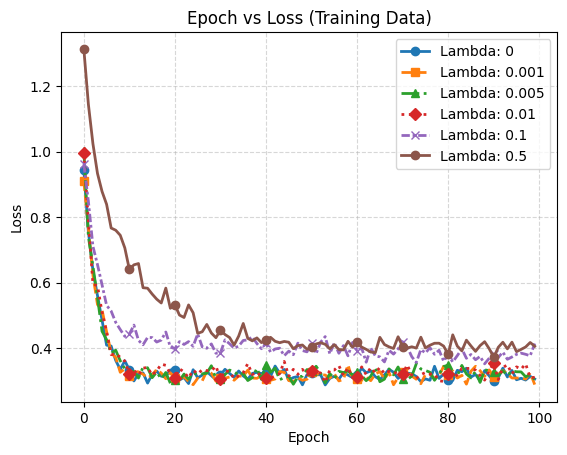

In [5]:
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'x']

for i, reg in enumerate(epoch_loss_train_histories.keys()):
    plt.plot(
        epoch_loss_train_histories[reg]["epoch_loss_train_history"],
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        markevery=10,          
        linewidth=2,
        label=f"Lambda: {reg}"
    )

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss (Training Data)")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

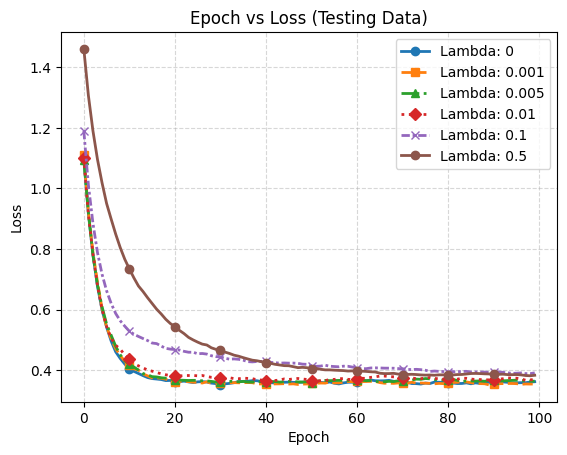

In [6]:
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'x']

for i, reg in enumerate(epoch_loss_test_histories.keys()):
    plt.plot(
        epoch_loss_test_histories[reg]["epoch_loss_test_history"],
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        markevery=10,          
        linewidth=2,
        label=f"Lambda: {reg}"
    )

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss (Testing Data)")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Text(0, 0.5, 'convergence epoch')

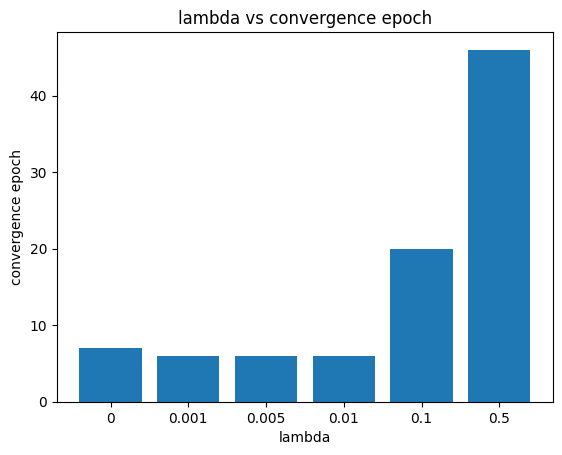

In [7]:
training_convergence_epoch = {}
for i, reg in enumerate(epoch_loss_train_histories.keys()):
    training_convergence_epoch[f'{reg}'] = epoch_loss_train_histories[reg]["training_convergence_epoch"]

plt.bar(*zip(*training_convergence_epoch.items()))
plt.title("lambda vs convergence epoch")
plt.xlabel("lambda")
plt.ylabel("convergence epoch")

Text(0, 0.5, 'convergence epoch')

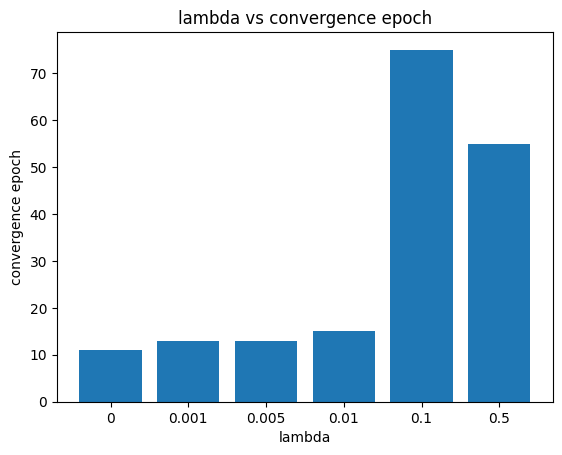

In [8]:
testing_convergence_epoch = {}
for i, reg in enumerate(epoch_loss_test_histories.keys()):
    testing_convergence_epoch[f'{reg}'] = epoch_loss_test_histories[reg]["testing_convergence_epoch"]

plt.bar(*zip(*testing_convergence_epoch.items()))
plt.title("lambda vs convergence epoch")
plt.xlabel("lambda")
plt.ylabel("convergence epoch")

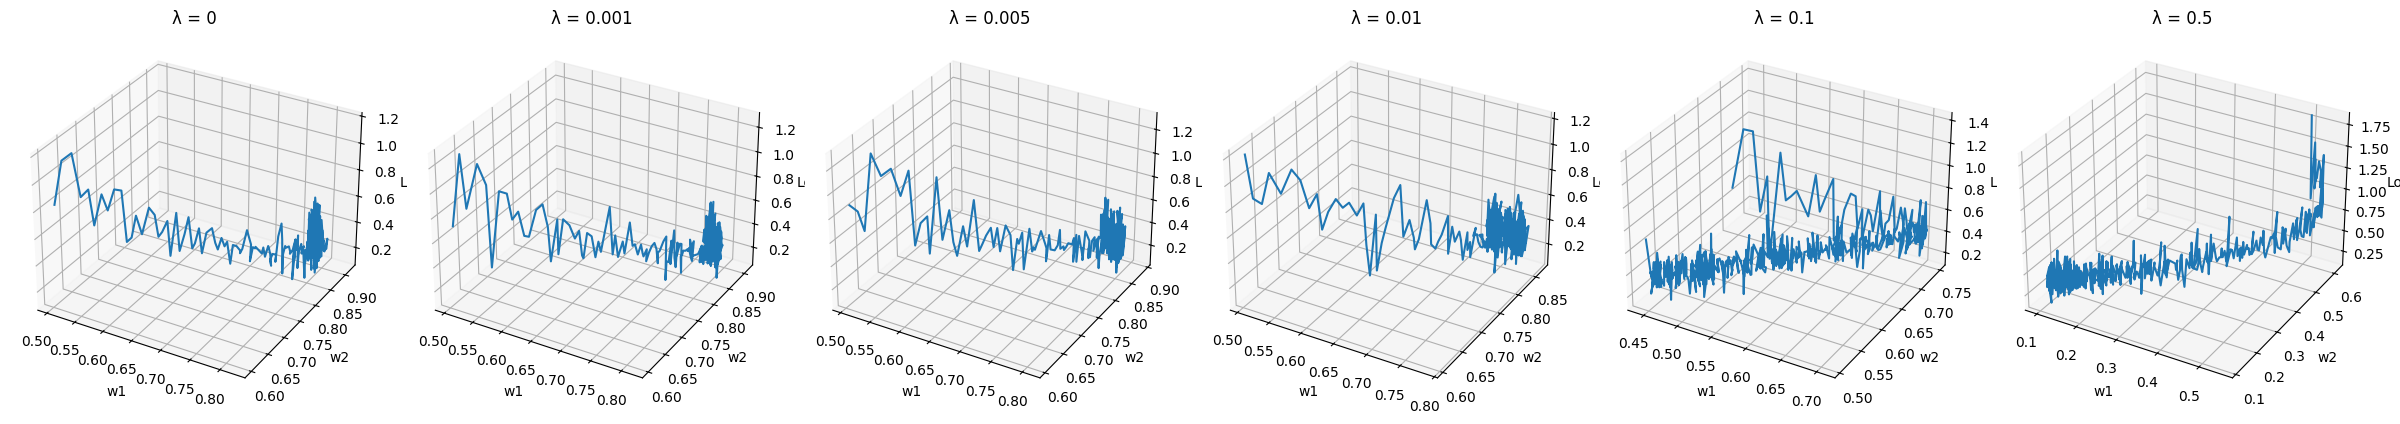

In [11]:
regs = list(epoch_loss_train_histories.keys())
n = len(regs)

fig = plt.figure(figsize=(4*n, 4))

for i, reg in enumerate(regs):
    w1_vals = [w[0].item() for w in epoch_loss_train_histories[reg]["ws_history"]]
    w2_vals = [w[1].item() for w in epoch_loss_train_histories[reg]["ws_history"]]
    loss_vals = epoch_loss_train_histories[reg]["loss_history"]

    ax = fig.add_subplot(1, n, i+1, projection='3d')
    ax.plot(w1_vals, w2_vals, loss_vals)

    ax.set_title(f"λ = {reg}")
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")
    ax.set_zlabel("Loss")

plt.tight_layout()
plt.show()

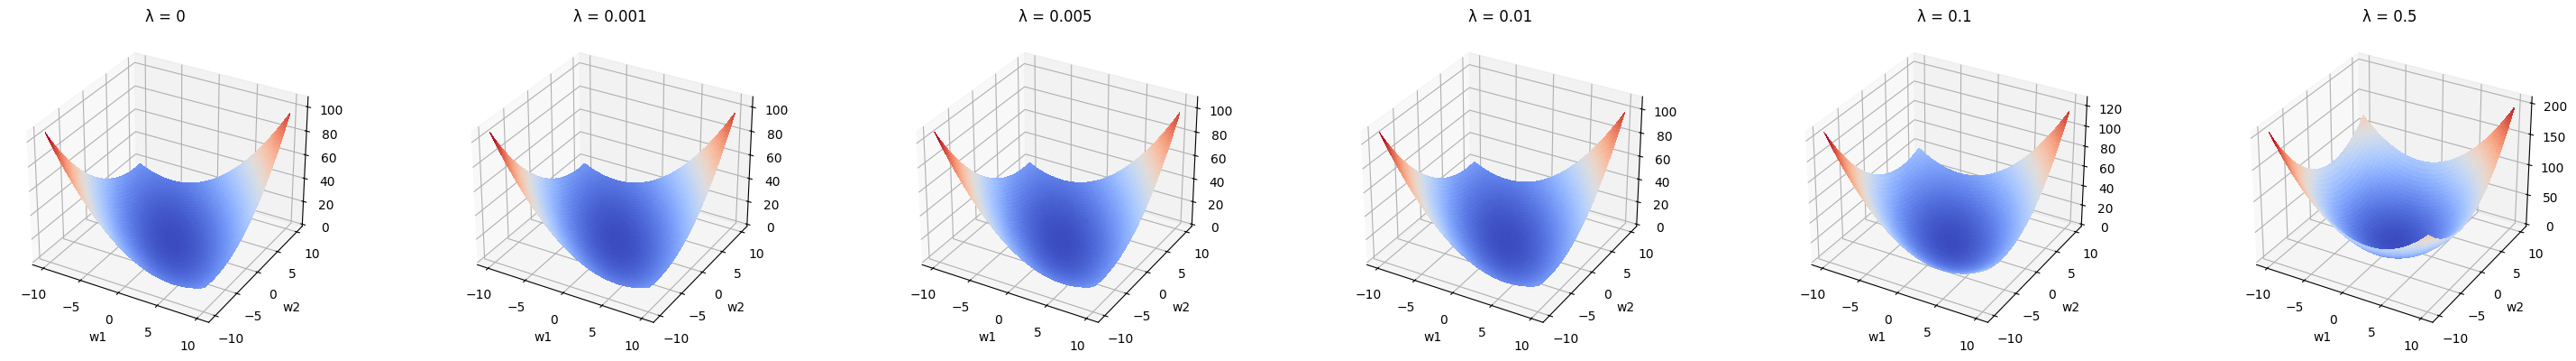

In [12]:
n = len(lambda_regs)
fig = plt.figure(figsize=(5*n, 4))

for idx, reg in enumerate(lambda_regs):

    W1 = np.linspace(-10, 10, 100)
    W2 = np.linspace(-10, 10, 100)

    W1_grid, W2_grid = np.meshgrid(W1, W2)
    L_surface = np.zeros_like(W1_grid)

    X_full = []
    Y_full = []

    for xb, yb in train_dataloader:
        X_full.append(xb)
        Y_full.append(yb)

    X_full = torch.cat(X_full)
    Y_full = torch.cat(Y_full)

    for i in range(W1_grid.shape[0]):
        for j in range(W1_grid.shape[1]):
            w_temp = torch.tensor([W1_grid[i, j], W2_grid[i, j]], dtype=torch.float32)
            y_hat = (X_full @ w_temp).unsqueeze(1) + b
            L_surface[i, j] = loss_fn(y_hat, Y_full, w_temp, reg).mean().item()

    ax = fig.add_subplot(1, n, idx+1, projection="3d")

    surf = ax.plot_surface(
        W1_grid, W2_grid, L_surface,
        cmap=cm.coolwarm,
        linewidth=0,
        antialiased=False
    )

    ax.set_title(f"λ = {reg}")
    ax.set_xlabel("w1")
    ax.set_ylabel("w2")

plt.tight_layout()
plt.show()